In [49]:
!python --version

Python 3.10.14


In [50]:
!pip install torch
import torch
def check_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using GPU:", torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

check_device()

Using GPU: Tesla T4


device(type='cuda')

In [15]:
%%capture
!pip install --user "unsloth @ git+https://github.com/unslothai/unsloth.git"
# Install other dependencies
!pip install --user --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes datasets sentencepiece xxhash openpyxl
!pip install --user rouge-score sentence-transformers --quiet
!pip install et_xmlfile --quiet

In [53]:
from unsloth import FastLanguageModel
import torch
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
from google.cloud import storage
import json
import os, joblib, logging, argparse

In [54]:
max_seq_length = 2048
per_device_train_batch_size = 2
gradient_accumulation_steps = 4
warmup_steps = 5
max_steps = 15
bucket_name = 'airflow-dags-leetsummarizer'
data_file_path = 'dags/data/preprocessed_data.json'

In [36]:
def load_data_from_gcs(bucket_name, file_path):
    """Load JSON data from Google Cloud Storage"""
    # Initialize a client
    client = storage.Client()

    # Get the bucket
    bucket = client.bucket(bucket_name)

    # Get the blob (file) from the bucket
    blob = bucket.blob(file_path)

    # Download blob as a string
    data = blob.download_as_string()

    # Parse the JSON data
    json_data = json.loads(data)

    return json_data

In [32]:
def upload_to_gcs(source_file_name, bucket_name, destination_blob_name):
    """Uploads a file to Google Cloud Storage.

    Args:
        source_file_name (str): The path to the file to upload.
        bucket_name (str): The name of the GCS bucket.
        destination_blob_name (str): The destination path in the GCS bucket.
    """
    # Initialize a storage client
    storage_client = storage.Client()

    # Get the bucket
    bucket = storage_client.bucket(bucket_name)

    # Create a blob object from the filepath
    blob = bucket.blob(destination_blob_name)

    # Upload the file to GCS
    blob.upload_from_filename(source_file_name)

In [33]:
def load_model_tokenizer():
    dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

    model, tokenizer = FastLanguageModel.from_pretrained(
        # model_name = "unsloth/llama-3-8b-bnb-4bit",
        # model_name = 'unsloth/llama-3-8b-Instruct-bnb-4bit',
        # model_name = 'unsloth/mistral-7b-instruct-v0.3-bnb-4bit',
        model_name = 'unsloth/mistral-7b-v0.3-bnb-4bit',
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit
    )
    return model, tokenizer
model, tokenizer = load_model_tokenizer()

==((====))==  Unsloth: Fast Mistral patching release 2024.6
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth: Will load unsloth/mistral-7b-v0.3-bnb-4bit as a legacy tokenizer.


In [34]:
def load_peft_model(model):
    model = FastLanguageModel.get_peft_model(
        model,
        r = 16, # rank of LoRA
        target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                        "gate_proj", "up_proj", "down_proj",],
        lora_alpha = 16,
        lora_dropout = 0,
        bias = "none", # No bias added for optimal performance
        use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
        random_state = 3407,
        use_rslora = False,
        loftq_config = None,
    )
    return model
model = load_peft_model(model)

In [38]:
def prepare_data(tokenizer):
    data = load_data_from_gcs(bucket_name, data_file_path)
    EOS_TOKEN = tokenizer.eos_token
    prompt = "Summarize the provided code solution for the given problem in simple, plain English text. Explain in simple text how the code works to solve the specified problem."
    df = pd.DataFrame(data)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df["Question"] = (
        prompt
        + "\n Question: )"
        + train_df["Question"]
        + "\n Code: )"
        + train_df["Code"]
        + "\n Plain Text: )"
        + train_df["Plain Text"]
        + EOS_TOKEN
    )

    custom_ds = pd.DataFrame()
    custom_ds["text"] = df["Question"]
    dataset = Dataset.from_pandas(custom_ds)
    return dataset, test_df, prompt
dataset, test_df, prompt = prepare_data(tokenizer)

Map (num_proc=2):   0%|          | 0/26 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 26 | Num Epochs = 5
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 15
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,0.045400
2,0.053200
3,0.052500
4,0.047600
5,0.066100
6,0.037300
7,0.057500
8,0.045000
9,0.094800
10,0.031100


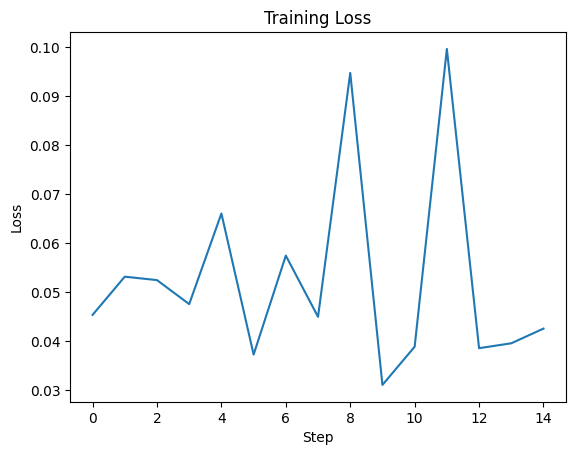

In [57]:
def train_model(model, tokenizer, train_data, test_df, prompt):
    trainer = SFTTrainer(
        model = model,
        tokenizer = tokenizer,
        train_dataset = dataset,
        dataset_text_field = "text",
        max_seq_length = max_seq_length,
        dataset_num_proc = 2,
        packing = False,
        args = TrainingArguments(
            per_device_train_batch_size = per_device_train_batch_size,
            gradient_accumulation_steps = gradient_accumulation_steps,
            warmup_steps = warmup_steps,
            max_steps = max_steps,
            learning_rate = 2e-4,
            fp16 = not is_bfloat16_supported(),
            bf16 = is_bfloat16_supported(),
            logging_steps = 1,
            optim = "adamw_8bit",
            weight_decay = 0.01,
            lr_scheduler_type = "linear",
            seed = 3407,
            output_dir = "outputs",
        ),
    )
    trainer_stats = trainer.train()
    loss_values = []
    for log in trainer.state.log_history:
        if 'loss' in log:
            loss_values.append(log['loss'])
    # Plot the loss values and save in bucket airflow-dags-leetsummarizer
    plt.plot(loss_values)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.savefig('/tmp/training_loss.png')
    destination_blob_name = 'dags/data/training_loss.png'
    upload_to_gcs('/tmp/training_loss.png', bucket_name, destination_blob_name)
    #Save model locally
    model_directory = "lora_model"
    gcs_model_folder = 'dags/model/lora_model/'
    model.save_pretrained(model_directory)
    for root, dirs, files in os.walk(model_directory):
        for file in files:
            local_file_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_file_path, model_directory)
            destination_blob_name = os.path.join(gcs_model_folder, relative_path)
            upload_to_gcs(local_file_path, bucket_name, destination_blob_name)
    return trainer_stats
trainer_stats = train_model(model, tokenizer, dataset, test_df, prompt)

In [59]:
model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit_forced",)

Unsloth: Merging 4bit and LoRA weights to 4bit...
This might take 5 minutes...


/home/jupyter/.local/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Done.
Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 10 minutes for Llama-7b... Done.


In [60]:
model_directory = "model"
gcs_model_folder = 'dags/model/lora_model/'
for root, dirs, files in os.walk(model_directory):
    for file in files:
        local_file_path = os.path.join(root, file)
        relative_path = os.path.relpath(local_file_path, model_directory)
        destination_blob_name = os.path.join(gcs_model_folder, relative_path)
        upload_to_gcs(local_file_path, bucket_name, destination_blob_name)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


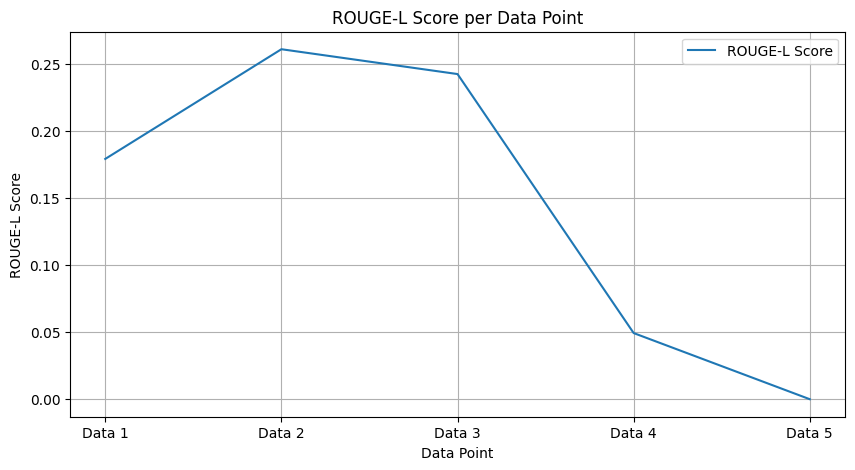

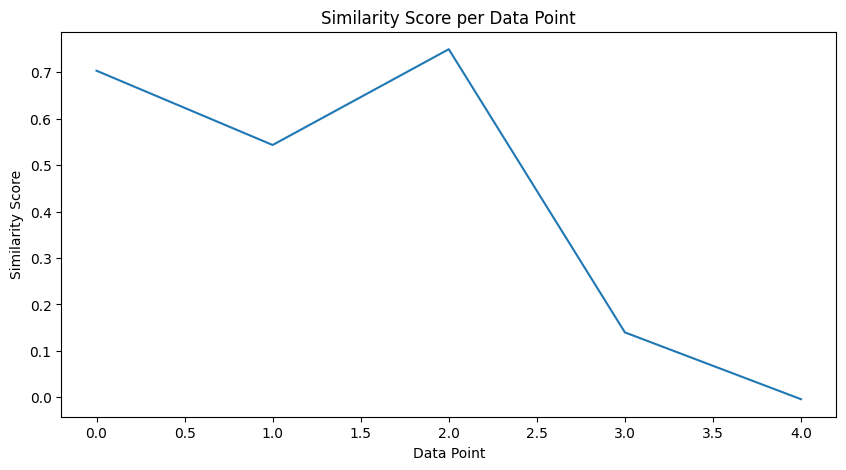

In [45]:
def evaluate_model(model, test_df, prompt, tokenizer):
    similarity_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")


    # Assuming test_df is a pandas DataFrame where each row represents a data point
    roguel_values = []
    similarity_values = []
    model.eval()  # Set the model to evaluation mode

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Iterate over each row in test_df, skipping the first row (index 0)
    for idx in range(1, len(test_df)):
        data_point = test_df.iloc[idx]
        with torch.no_grad():
            test_text = prompt + "\n Question: " + data_point["Question"] + "\n Code: " + data_point["Code"] + "\n Plain Text: " + EOS_TOKEN
            
            # Tokenize and encode the test_text
            inputs = tokenizer([test_text], return_tensors="pt").to("cuda")
            
            # Generate text using the model
            outputs = model.generate(**inputs, max_new_tokens=200)

            generated_sequence = outputs[0]
            input_length = inputs['input_ids'].shape[1]  # Length of the input text tokens
            new_tokens = generated_sequence[input_length:]  # Exclude the input tokens

            generated_text = tokenizer.decode(new_tokens, skip_special_tokens=True)
            
            # Decode the generated sequence
            #generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            actual_text = data_point["Plain Text"]
            
            # Compute ROUGE scores
            scores = scorer.score(generated_text, actual_text)
            
            # ROUGE-L score can be used as a single metric for evaluation
            rouge_l_score = scores['rougeL'].fmeasure
            
            # Append ROUGE-L score to test_loss_values
            roguel_values.append(rouge_l_score)
            embeddings1 = similarity_model.encode(generated_text, convert_to_tensor=True)
            embeddings2 = similarity_model.encode(actual_text, convert_to_tensor=True)

            similarity = util.pytorch_cos_sim(embeddings1, embeddings2)
            similarity_values.append(similarity.item())
    # Plot the ROUGE-L scores and similarity scores and save in bucket airflow-dags-leetsummarizer
    plt.figure(figsize=(10, 5))
    plt.plot(roguel_values, label='ROUGE-L Score')
    plt.xlabel('Data Point')
    plt.ylabel('ROUGE-L Score')
    plt.title('ROUGE-L Score per Data Point')
    plt.xticks(range(len(roguel_values)), [f'Data {i+1}' for i in range(len(roguel_values))])
    plt.legend()
    plt.grid(True)
    plt.savefig('/tmp/rouge_l_score.png')
    destination_blob_name = 'dags/data/rouge_l_score.png'
    upload_to_gcs('/tmp/rouge_l_score.png', bucket_name, destination_blob_name)

    plt.figure(figsize=(10, 5))
    plt.plot(similarity_values, label='Similarity Score')
    plt.xlabel('Data Point')
    plt.ylabel('Similarity Score')
    plt.title('Similarity Score per Data Point')
    plt.savefig('/tmp/similarity_score.png')
    destination_blob_name = 'dags/data/similarity_score.png'
    upload_to_gcs('/tmp/similarity_score.png', bucket_name, destination_blob_name)
    return roguel_values, similarity_values
roguel_values, similarity_values = evaluate_model(model, test_df, prompt, tokenizer)